In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd
import math
import re

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Data Exploration

> We will choose malomodaniels's dataset since it contains the highest number of high quality data

In [8]:
train_data = pd.read_csv("malomodaniels-data/Train_Data.csv")
validation_data = pd.read_csv("malomodaniels-data/Validation_Data.csv")
test_data = pd.read_csv("malomodaniels-data/Test_Data.csv")

print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)
print("total :", train_data.shape[0]+validation_data.shape[0]+test_data.shape[0])

(6726, 3)
(2227, 3)
(2227, 3)
total : 11180


In [9]:
train_data.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [10]:
train_len = {'real tweets':len(train_data.loc[train_data['label']=='real']), 'fake tweets':len(train_data.loc[train_data['label']=='fake'])}
val_len = {'real tweets':len(validation_data.loc[validation_data['label']=='real']), 'fake tweets':len(validation_data.loc[validation_data['label']=='fake'])}
test_len = {'real tweets':len(test_data.loc[test_data['label']=='real']), 'fake tweets':len(test_data.loc[test_data['label']=='fake'])}

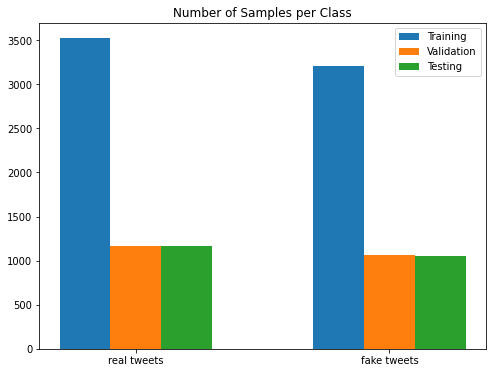

In [11]:
X_axis = np.arange(2)

plt.figure(figsize=(8,6))
plt.bar(X_axis-0.2, train_len.values(),0.2, label="Training")
plt.bar(X_axis, val_len.values(), 0.2,label='Validation')
plt.bar(X_axis+0.2, test_len.values(),0.2, label='Testing')

plt.title("Number of Samples per Class")
plt.xticks(X_axis, val_len.keys())
plt.legend()

plt.show()

# Preprocessing

## Data Cleaning

In [12]:
def clean_sequence(seq):
    punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~'
    stop_words = set(stopwords.words('english'))

    # remove urls
    seq = re.sub('http[s]?://\S+', '', seq)    
    seq = re.sub('#', '', seq)    
    # remove punctuations
    table = str.maketrans('', '', punctuation)
    words = [w.translate(table).lower() for w in seq.split(" ")]    
    
    # remove usernames, tags and stopwords
    words = [w for w in words if len(w)>=1 and w[0] is not "@" and w not in stop_words]
    
    return ' '.join(words)

In [13]:
cleaned_data = [clean_sequence(seq) for seq in train_data['tweet']]

In [14]:
train_data[:4]['tweet']

0    The CDC currently reports 99031 deaths. In gen...
1    States reported 1121 deaths a small rise from ...
2    Politically Correct Woman (Almost) Uses Pandem...
3    #IndiaFightsCorona: We have 1524 #COVID testin...
Name: tweet, dtype: object

In [15]:
cleaned_data[:4]

['cdc currently reports 99031 deaths general discrepancies death counts different sources small explicable death toll stands roughly 100000 people today',
 'states reported 1121 deaths small rise last tuesday southern states reported 640 deaths',
 'politically correct woman almost uses pandemic excuse reuse plastic bag coronavirus nashville',
 'indiafightscorona 1524 covid testing laboratories india 25th august 2020 36827520 tests done dg staysafe indiawillwin']

In [16]:
x_train = [clean_sequence(seq) for seq in train_data['tweet']]
y_train = np.array(train_data['label'])

In [17]:
x_val = [clean_sequence(seq) for seq in validation_data['tweet']]
y_val = np.array(validation_data['label'])

In [18]:
x_test = [clean_sequence(seq) for seq in test_data['tweet']]
y_test = np.array(test_data['label'])

# Model I : LSTM

## Keras Tokenizer

In [19]:
# Tokenize data
def tokenize_tweets(tweets, maxlen, max_words):
  tokenizer = Tokenizer(num_words=max_words)

  # Create word index based on training data
  tokenizer.fit_on_texts(x_train)
  # convert strings into lists of integer indices based on word index
  sequences = tokenizer.texts_to_sequences(tweets)

  # View the computed word index
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  # Make all sequences same size (adds zeros in the begining)
  sequences_padded =  pad_sequences(sequences, maxlen=maxlen)
  return sequences_padded, word_index

In [20]:
maxlen=100
max_words = 10000

x_train_tokenized, word_index = tokenize_tweets(x_train, maxlen, max_words)
x_val_tokenized, word_index = tokenize_tweets(x_val, maxlen, max_words)
x_test_tokenized, word_index = tokenize_tweets(x_test, maxlen, max_words)

Found 17264 unique tokens.
Found 17264 unique tokens.
Found 17264 unique tokens.


In [21]:
# Tokenize Labels
def tokenize_labels(labels):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(y_train)
  labels = tokenizer.texts_to_sequences(labels)
  return np.array(labels, dtype='float64').reshape(len(labels),) - 1

In [22]:
y_train_tokenized = tokenize_labels(y_train)
y_val_tokenized = tokenize_labels(y_val)
y_test_tokenized = tokenize_labels(y_test)

## GloVe word-embedding

In [23]:
#!wget https://nlp.stanford.edu/data/glove.6B.zip

In [24]:
# Parsing the GloVe word-embeddings file
glove_dir = 'glove_6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [25]:
# Preparing the GloVe word-embeddings matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim)) 

for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

## Modeling

In [26]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM

In [27]:
# LSTM Model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(embedding_dim,dropout=0.5, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 100, 100)          80400     
                                                                 
 lstm_1 (LSTM)               (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,097,457
Trainable params: 1,097,457
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Loading pretrained word embeddings into the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [30]:
history = model.fit(x_train_tokenized, y_train_tokenized, epochs=15, batch_size=64, validation_data=(x_val_tokenized, y_val_tokenized))
# model.save_weights('models/LSTM/pre_trained_lstm_glove_model_final.h5')

Epoch 1/15
106/106 [==============================] - 11s 21ms/step - loss: 0.4590 - acc: 0.7872 - val_loss: 0.3847 - val_acc: 0.8321
Epoch 2/15
106/106 [==============================] - 2s 15ms/step - loss: 0.3820 - acc: 0.8299 - val_loss: 0.3843 - val_acc: 0.8361
Epoch 3/15
106/106 [==============================] - 2s 15ms/step - loss: 0.3526 - acc: 0.8414 - val_loss: 0.3190 - val_acc: 0.8657
Epoch 4/15
106/106 [==============================] - 2s 15ms/step - loss: 0.3288 - acc: 0.8641 - val_loss: 0.3417 - val_acc: 0.8482
Epoch 5/15
106/106 [==============================] - 2s 15ms/step - loss: 0.3054 - acc: 0.8705 - val_loss: 0.3046 - val_acc: 0.8743
Epoch 6/15
106/106 [==============================] - 2s 15ms/step - loss: 0.3026 - acc: 0.8677 - val_loss: 0.3024 - val_acc: 0.8738
Epoch 7/15
106/106 [==============================] - 2s 15ms/step - loss: 0.2782 - acc: 0.8805 - val_loss: 0.2986 - val_acc: 0.8752
Epoch 8/15
106/106 [==============================] - 2s 15ms/step -

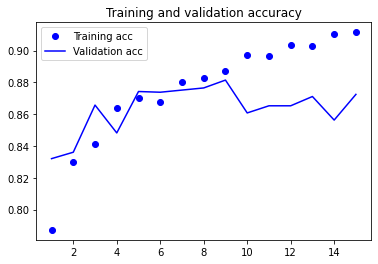

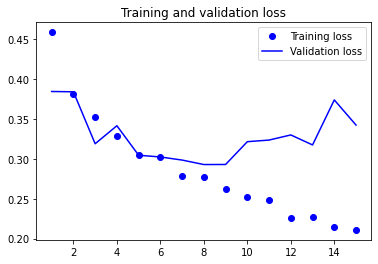

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
model.evaluate(x=x_test_tokenized, y=y_test_tokenized)

70/70 [==============================] - 0s 6ms/step - loss: 0.3099 - acc: 0.8819


[0.3098645806312561, 0.881903886795044]

# Model II : BERT

**BERT :** Bidirectional Encoder Representations from Transformers

In [33]:
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.2 MB/s 
     |████████████████████████████████| 101 kB 12.9 MB/s 
     |████████████████████████████████| 6.6 MB 46.7 MB/s 
     |████████████████████████████████| 596 kB 69.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## BERT Tokenizer & word-embeeding

**BERT Tokens :**

**[CLS] :** CLS stands for classification. This token represents sentence-level classification. It is added at the beginning of all the sentences.

**[SEP] :** This token makes BERT know the start of the next sentence. It is added at the end of each sentence.

**[PAD] :** PAD stands for padding. Padding is added up to the maximum length of the sentence.


**Dictionary :** It hashes word string and generates the word id. This word-id can then be looked up in the embeddings look-up table to get the feature vector.

**Word embeddings look up table :** Every row corresponds to a unique word id. Bert has a vocabulary of 30k tokens. Each token has 768 features in the embedding look-up table.

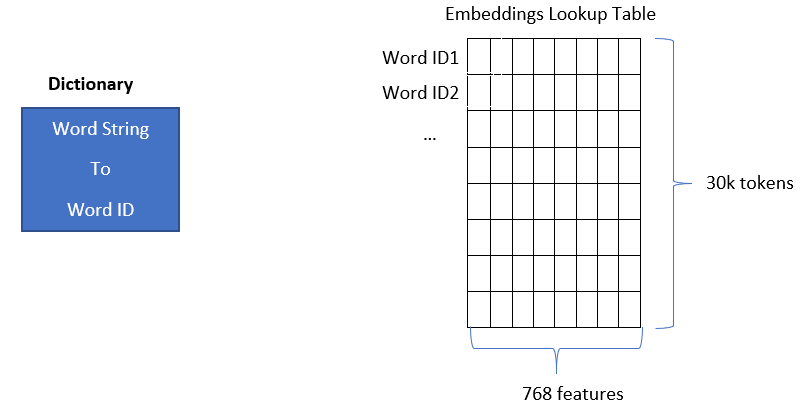

In [34]:
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
import tensorflow as tf

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [36]:
def mask_inputs_for_bert(tweets, max_len):
  input_ids = []
  attention_masks = []
  i=0

  for tweet in tweets:
    encoded_dict = tokenizer.encode_plus(
        tweet,
        add_special_tokens = True, # add [CLS] & [SEP]
        max_length = max_len,
        pad_to_max_length = True,
        return_attention_mask = True
    )
    # Tokenized tweet
    input_ids.append(encoded_dict['input_ids'])
    # attention mask (differenciate padding from non padding)
    attention_masks.append(encoded_dict['attention_mask']) 

  input_ids = tf.convert_to_tensor(input_ids)
  attention_masks = tf.convert_to_tensor(attention_masks)
  return input_ids, attention_masks

In [37]:
max_len = 100
x_train_tokenized, train_mask = mask_inputs_for_bert(x_train, max_len)
x_val_tokenized, val_mask = mask_inputs_for_bert(x_val, max_len)
x_test_tokenized, test_mask = mask_inputs_for_bert(x_test, max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Modeling

In [38]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [41]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
model.compile(loss=loss, optimizer=optimizer,metrics=[metric])

In [42]:
history = model.fit([x_train_tokenized, train_mask], 
                    y_train_tokenized, 
                    batch_size=32, 
                    epochs=4, 
                    validation_data=([x_val_tokenized, val_mask], y_val_tokenized))

Epoch 1/4
211/211 [==============================] - 164s 686ms/step - loss: 0.3241 - accuracy: 0.8604 - val_loss: 0.2197 - val_accuracy: 0.9174
Epoch 2/4
211/211 [==============================] - 143s 677ms/step - loss: 0.1504 - accuracy: 0.9493 - val_loss: 0.2426 - val_accuracy: 0.9115
Epoch 3/4
211/211 [==============================] - 143s 677ms/step - loss: 0.0807 - accuracy: 0.9731 - val_loss: 0.2907 - val_accuracy: 0.9035
Epoch 4/4
211/211 [==============================] - 143s 677ms/step - loss: 0.0438 - accuracy: 0.9842 - val_loss: 0.3167 - val_accuracy: 0.9106


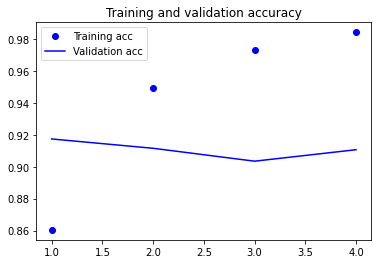

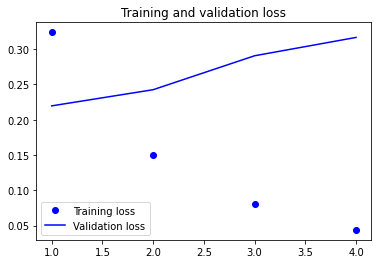

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
model.evaluate(x=[x_test_tokenized,test_mask], y=y_test_tokenized)

70/70 [==============================] - 15s 213ms/step - loss: 0.2535 - accuracy: 0.9273


[0.25345033407211304, 0.9272564053535461]